## **0. 루브릭**

| 평가문항 | 상세기준 |
| --- | --- |
| 1. CutMix와 MixUp 기법을 ResNet50 분류기에 성공적으로 적용하였는가? | CutMix와 MixUp을 적용한 데이터셋으로 훈련한 각각의 ResNet 모델이 수렴하였다. |
| 2. 다양한 실험을 통해 태스크에 최적의 Augmentation 기법을 찾아내었는가? | 각 Augmentation 기법을 적용하고, 그에 따른 성능 비교 분석 및 문제점을 서술하였음 |
| 3. 여러가지 Augmentation 기법을 적용한 결과를 체계적으로 비교분석하였는가? | 기본 Augmentation, CutMix, MixUp이 적용된 결과를 시각화와 함께 체계적으로 분석하였다. |

## **1. 실험하기**

### **1) Augmentation을 적용한 데이터셋 만들기**

**Q. 아래는 CutMix를 적용할 수 있도록 변경한 apply_normalize_on_dataset()입니다. batch() 함수 뒤에 CutMix가 오도록 만들어야합니다. 그 이유가 뭘까요?**

* **배치 단위 적용 필요** : CutMix는 여러 이미지와 라벨을 섞어야 하므로 배치 단위로 처리하는 것이 자연스럽습니다.
* **효율성 및 성능 향상** : 배치 단위 처리는 하드웨어 가속기를 최대한 활용할 수 있어 계산적으로 효율적입니다.
* **정확한 라벨 생성** : 배치 후에 각 이미지의 라벨을 알고 있어야 라벨도 정확히 섞을 수 있습니다.
* **일관된 데이터 증강** : 배치 후에 적용하면 데이터 증강이 일관되고 체계적으로 이루어져 모델 학습에 도움이 됩니다.

In [51]:
# 라이브러리 불러오기
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [52]:
# stanford_dogs 데이터셋 불러오기
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

In [53]:
# 데이터 feature 정보 확인하기
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})


In [54]:
# 데이터셋 개수 확인하기
print(tf.data.experimental.cardinality(ds_train))    # 훈련 데이터셋
print(tf.data.experimental.cardinality(ds_test))     # 테스트 데이터셋

tf.Tensor(12000, shape=(), dtype=int64)
tf.Tensor(8580, shape=(), dtype=int64)


In [55]:
# 데이터셋 클래스 개수 및 구성 확인하기
num_classes = ds_info.features["label"].num_classes
num_classes

120

In [56]:
# 데이터셋 구성 확인하기
ds_info.features["label"].names

['n02085620-chihuahua',
 'n02085782-japanese_spaniel',
 'n02085936-maltese_dog',
 'n02086079-pekinese',
 'n02086240-shih-tzu',
 'n02086646-blenheim_spaniel',
 'n02086910-papillon',
 'n02087046-toy_terrier',
 'n02087394-rhodesian_ridgeback',
 'n02088094-afghan_hound',
 'n02088238-basset',
 'n02088364-beagle',
 'n02088466-bloodhound',
 'n02088632-bluetick',
 'n02089078-black-and-tan_coonhound',
 'n02089867-walker_hound',
 'n02089973-english_foxhound',
 'n02090379-redbone',
 'n02090622-borzoi',
 'n02090721-irish_wolfhound',
 'n02091032-italian_greyhound',
 'n02091134-whippet',
 'n02091244-ibizan_hound',
 'n02091467-norwegian_elkhound',
 'n02091635-otterhound',
 'n02091831-saluki',
 'n02092002-scottish_deerhound',
 'n02092339-weimaraner',
 'n02093256-staffordshire_bullterrier',
 'n02093428-american_staffordshire_terrier',
 'n02093647-bedlington_terrier',
 'n02093754-border_terrier',
 'n02093859-kerry_blue_terrier',
 'n02093991-irish_terrier',
 'n02094114-norfolk_terrier',
 'n02094258-norwi

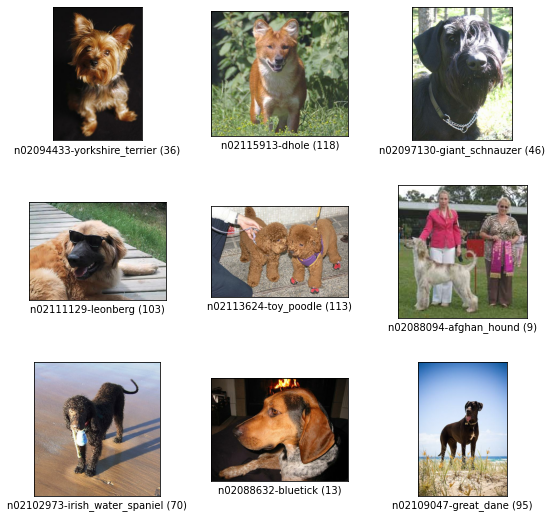

In [57]:
# 학습용 데이터셋 확인하기
fig = tfds.show_examples(ds_train, ds_info)

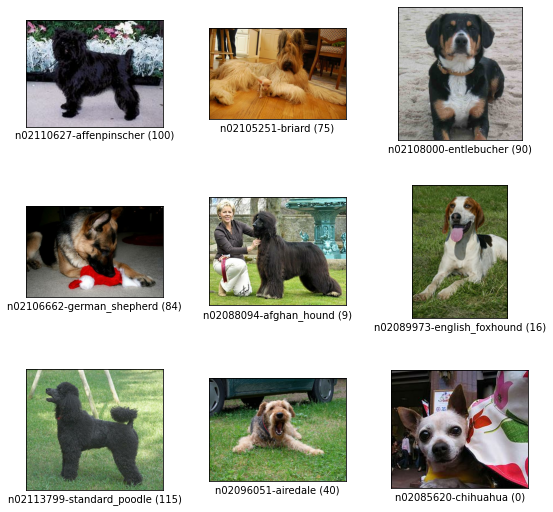

In [58]:
# 테스트용 데이터셋 확인하기
fig = tfds.show_examples(ds_test, ds_info)

In [59]:
# 기본적인 전처리 함수 정의하기
def normalize_and_resize_img(image, label):
    # 이미지를 정규화하고 크기를 조정하기: `uint8` -> `float32`

    # 이미지를 224x224 크기로 조정하기
    image = tf.image.resize(image, [224, 224])
    # 이미지를 float32 타입으로 변환하고 255로 나누어 정규화하기
    return tf.cast(image, tf.float32) / 255., label

In [60]:
# augmentation 함수 정의하기
def augment(image, label):
    # 이미지를 무작위로 좌우 반전하고 밝기를 조정하기
    # 이미지를 무작위로 좌우 반전하기
    image = tf.image.random_flip_left_right(image)
    # 이미지를 무작위로 밝기 조정하기 (최대 0.2 범위 내에서)
    image = tf.image.random_brightness(image, max_delta=0.2)
    # 이미지의 값을 0과 1 사이로 클리핑하기
    image = tf.clip_by_value(image, 0, 1)
    return image, label

In [61]:
# 원-핫 인코딩하기
def onehot(image, label):
    # 레이블을 원-핫 인코딩하기
    label = tf.one_hot(label, num_classes)
    return image, label

In [62]:
# 데이터셋(ds)을 가공하는 메인함수 구현하기
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16,
                               with_aug=False, with_cutmix=False):
    # 데이터셋에 정규화와 선택적 증강을 적용하기
    ds = ds.map(
        normalize_and_resize_img,
        num_parallel_calls=2  # 병렬 처리로 속도 향상하기
    )
    if not is_test and with_aug:
        # 학습 데이터셋에 증강을 적용하기
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)  # 배치 크기로 묶기
    if not is_test and with_cutmix:
        # CutMix를 적용할 경우 해당 함수를 사용하기
        ds = ds.map(
            cutmix,
            num_parallel_calls=2  # 병렬 처리로 속도 향상하기
        )
    else:
        # 그렇지 않으면 원-핫 인코딩 적용하기
        ds = ds.map(
            onehot,
            num_parallel_calls=2  # 병렬 처리로 속도 향상시키기
        )
    if not is_test:
        # 학습 데이터셋인 경우 반복 및 셔플 적용하기
        ds = ds.repeat()  # 무한 반복하기
        ds = ds.shuffle(200)  # 200개 버퍼 크기로 셔플하기

    # 자동으로 적절한 프리페치 크기 설정하기
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [63]:
# augmentation을 적용하지 않은 학습 데이터셋을 만들기
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)

In [64]:
# augmentation을 적용한 학습 데이터셋을 만들기
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)

In [65]:
# 테스트 데이터셋을 만들기
# 테스트 데이터셋에는 augmentation을 적용하지 않기
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

### **2) 모델 만들기**

비교 실험을 위한 모델을 만들어봅시다.

* No Augmentation 모델
* Augmentation 모델
* Augmentation + CutMix 모델
* Augmentation + MixUp 모델

**cutmix 적용 함수 만들기**

In [66]:
# bounding box 구현하는 함수 만들기
# 첫 번째 이미지 a를 바탕 이미지로 하고 거기에 삽입할 두 번째 이미지 b가 있을 때,
# a에 삽입될 영역의 바운딩 박스의 위치를 결정하는 함수를 먼저 구현해보기
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]  # 기본 이미지의 너비를 가져오기
    image_size_y = image_a.shape[0]  # 기본 이미지의 높이를 가져오기

    # 기본 이미지 내에서 무작위로 바운딩 박스의 중심을 설정하기
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)  # 중심의 무작위 x 좌표
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)  # 중심의 무작위 y 좌표

    # 무작위 스케일링 요소를 기반으로 바운딩 박스의 너비와 높이를 결정함
    width = tf.cast(image_size_x * tf.math.sqrt(1 - tf.random.uniform([], 0, 1)), tf.int32)  # 무작위 너비
    height = tf.cast(image_size_y * tf.math.sqrt(1 - tf.random.uniform([], 0, 1)), tf.int32)  # 무작위 높이

    # 바운딩 박스의 최소 및 최대 좌표를 계산하여 이미지 경계 내에 있도록 함.
    x_min = tf.math.maximum(0, x - width // 2)  # x_min이 0보다 작지 않도록 하기
    y_min = tf.math.maximum(0, y - height // 2)  # y_min이 0보다 작지 않도록 합하기
    x_max = tf.math.minimum(image_size_x, x + width // 2)  # x_max가 이미지 너비를 초과하지 않도록 하기
    y_max = tf.math.minimum(image_size_y, y + height // 2)  # y_max가 이미지 높이를 초과하지 않도록 하기

    return x_min, y_min, x_max, y_max  # 바운딩 박스의 좌표를 반환하기

In [67]:
# image_a에서 바운딩 박스 바깥쪽 영역을 가져오기
# image_b에서 바운딩 박스 안쪽 영역을 가져오기
# 둘의 이미지를 섞는 함수 구현하기
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]  # 기본 이미지의 너비를 가져오기
    image_size_y = image_a.shape[0]  # 기본 이미지의 높이를 가져오기

    # image_b의 왼쪽 바깥 영역
    middle_left = image_a[y_min:y_max, 0:x_min, :]

    # image_b의 안쪽 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]

    # image_b의 오른쪽 바깥 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :]

    # 위의 세 영역을 수평으로 결합하기
    middle = tf.concat([middle_left, middle_center, middle_right], axis=1)

    # 바운딩 박스 위쪽 영역
    top = image_a[0:y_min, :, :]

    # 바운딩 박스 아래쪽 영역
    bottom = image_a[y_max:image_size_y, :, :]

    # 위, 중간, 아래 영역을 수직으로 결합하여 최종 이미지를 생성하기
    mixed_img = tf.concat([top, middle, bottom], axis=0)

    return mixed_img  # 결합된 이미지를 반환하기

In [68]:
# 위에서 섞인 이미지 두 가지에 대하여 라벨을 만들 때
# 적절한 비율로 라벨을 합쳐주는 함수를 구현하기
def mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max, num_classes=num_classes):
    image_size_x = image_a.shape[1]  # 기본 이미지의 너비를 가져오기
    image_size_y = image_a.shape[0]  # 기본 이미지의 높이를 가져오기

    # 바운딩 박스 영역의 크기와 전체 이미지 영역의 크기를 계산하기
    mixed_area = (x_max - x_min) * (y_max - y_min)
    total_area = image_size_x * image_size_y

    # 바운딩 박스 영역이 전체 이미지에서 차지하는 비율을 계산하기
    ratio = tf.cast(mixed_area / total_area, tf.float32)

    # 레이블이 정수형일 경우 원-핫 인코딩으로 변환하기
    if len(label_a.shape) == 0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape) == 0:
        label_b = tf.one_hot(label_b, num_classes)

    # 두 레이블을 비율에 따라 섞기
    mixed_label = (1 - ratio) * label_a + ratio * label_b

    return mixed_label  # 혼합된 레이블을 반환하기

In [69]:
# mix_2_images()와 mix_2_label()을 활용하기
# cutmix 함수 구현하기
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]

        # 무작위로 다른 이미지와 레이블을 선택하기
        j = tf.cast(tf.random.uniform([], 0, batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]

        # 바운딩 박스 좌표를 얻기
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

        # 이미지를 혼합하기
        mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
        mixed_imgs.append(mixed_img)

        # 레이블을 혼합하기
        mixed_label = mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max, num_classes)
        mixed_labels.append(mixed_label)

    # 혼합된 이미지와 레이블을 텐서로 변환하고 형태 바꾸기
    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))

    return mixed_imgs, mixed_labels  # 혼합된 이미지와 레이블을 반환하기

**mixup 적용 함수 구현하기**

In [70]:
# 두 이미지를 mixup 하는 함수 구현하기
def mixup_2_images(image_a, image_b, label_a, label_b, num_classes=120):
    # 이미지와 레이블을 혼합할 비율을 무작위로 설정하기
    ratio = tf.random.uniform([], 0, 1)

    # 레이블이 정수형일 경우 원-핫 인코딩으로 변환하기
    if len(label_a.shape) == 0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape) == 0:
        label_b = tf.one_hot(label_b, num_classes)

    # 두 이미지를 비율에 따라 혼합하기
    mixed_image = (1 - ratio) * image_a + ratio * image_b

    # 두 레이블을 비율에 따라 혼합하기
    mixed_label = (1 - ratio) * label_a + ratio * label_b

    return mixed_image, mixed_label  # 혼합된 이미지와 레이블을 반환하기

In [71]:
# 두 이미지 쌍을 섞을 비율은 일정한 범위 내에서 랜덤하게 뽑고
# 해당 비율 값에 따라 두 이미지의 픽셀별 값과 라벨을 섞어주면 되는 함수 구현하기
# Mixup 함수 구현하기
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=num_classes):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]

        # 무작위로 다른 이미지와 레이블을 선택하기
        j = tf.cast(tf.random.uniform([], 0, batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]

        # 이미지를 혼합하기
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b, num_classes)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    # 혼합된 이미지와 레이블을 텐서로 변환하고 형태 변환하기
    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))

    return mixed_imgs, mixed_labels  # 혼합된 이미지와 레이블을 반환하기

모델은 **ResNet-50**을 사용하며, 함수 형태로 만들어 사용합니다.

In [72]:
# ResNet50 생성함수 적용하기
def create_ResNet50(include_top=False,         # 최상위 분류 레이어를 포함하지 않기
                    weights='imagenet',        # ImageNet 데이터셋으로 학습된 가중치를 사용하기
                    input_shape=(224,224,3),   # 입력 이미지의 크기 설정하기
                    pooling='avg',             # Global average pooling을 사용하기
                    num_classes=num_classes,
                    activation='softmax'):    # softmax 활성화 함수를 사용하기

    resnet50 = keras.models.Sequential([
        keras.applications.resnet.ResNet50(
            include_top=include_top,
            weights=weights,
            input_shape=input_shape,
            pooling=pooling,
        ),
        # 출력 레이어를 추가하기
        # 클래스 수만큼 유닛을 가지기
        keras.layers.Dense(num_classes, activation=activation)
    ])
    return resnet50

**No Augmentation 모델 구현하기**

In [73]:
# ds_train_no_aug으로 학습시킬 ResNet50 만들기
resnet50_no_aug = create_ResNet50()

94781440/94765736 [==============================] - 0s 0us/step


**Augmentation 모델 구현하기**

In [74]:
# ds_train_aug으로 학습시킬 ResNet50 만들기
resnet50_aug = create_ResNet50()

**Augmentation + CutMix 모델 구현하기**

In [75]:
# ds_train_aug_cutmix으로 학습시킬 ResNet50 만들기
resnet50_aug_cutmix = create_ResNet50()

**Augmentation + MixUp 모델 구현하기**

In [76]:
# ds_train_aug_mixup으로 학습시킬 ResNet50 만들기
resnet50_aug_mixup = create_ResNet50()

## **3) 모델 훈련하기**

모델을 훈련시켜 봅시다.

| 요소           | 선택 사항                        | 이유                                                        |
|----------------|---------------------------------|-------------------------------------------------------------|
| 옵티마이저     | SGD (Stochastic Gradient Descent)| 학습 안정성, 과적합 방지, 모멘텀과 함께 사용 가능            |
| 손실 함수      | categorical_crossentropy         | 다중 클래스 분류, 확률 분포 비교, 로그 손실 적용              |
| 평가지표       | accuracy                         | 직관적 이해, 간단하고 명확, 성능 비교에 유용                   |


In [77]:
# epochs 수 설정하기
EPOCHS = 20

**No Augmentation 모델 훈련하기**

In [78]:
# No Augmentation 컴파일하기
resnet50_no_aug.compile(
    # SGD 옵티마이저 사용하기
    optimizer='sgd',
    # 손실 함수로 categorical_crossentropy 사용하기
    loss='categorical_crossentropy',
    # 모델의 성능을 평가할 지표로 accuracy 사용하기
    metrics=['accuracy']
)

In [79]:
# No Augmentation 모델 훈련하기
history_resnet50 = resnet50_no_aug.fit(
    # Augmentation 사용하지 않기
    ds_train_no_aug,
    # 훈련을 20 epoch 동안 수행하기
    epochs=EPOCHS,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    validation_data=ds_test,
)

Epoch 1/20
750/750 [==============================] - 202s 200ms/step - loss: 2.2304 - accuracy: 0.4483 - val_loss: 3.2440 - val_accuracy: 0.2366
Epoch 2/20
750/750 [==============================] - 154s 205ms/step - loss: 0.7031 - accuracy: 0.8082 - val_loss: 1.0948 - val_accuracy: 0.6789
Epoch 3/20
750/750 [==============================] - 155s 207ms/step - loss: 0.2191 - accuracy: 0.9550 - val_loss: 0.9453 - val_accuracy: 0.7235
Epoch 4/20
750/750 [==============================] - 155s 207ms/step - loss: 0.0656 - accuracy: 0.9936 - val_loss: 0.9194 - val_accuracy: 0.7360
Epoch 5/20
750/750 [==============================] - 170s 227ms/step - loss: 0.0283 - accuracy: 0.9989 - val_loss: 0.9250 - val_accuracy: 0.7422
Epoch 6/20
750/750 [==============================] - 155s 207ms/step - loss: 0.0179 - accuracy: 0.9996 - val_loss: 0.9308 - val_accuracy: 0.7429
Epoch 7/20
750/750 [==============================] - 155s 207ms/step - loss: 0.0133 - accuracy: 0.9998 - val_loss: 0.9389 -

**Augmentation 모델 훈련하기**

In [80]:
# Augmentation 모델 컴파일하기
resnet50_aug.compile(
    # SGD 옵티마이저 사용하기
    optimizer='sgd',
    # 손실 함수로 categorical_crossentropy 사용하기
    loss='categorical_crossentropy',
    # 모델의 성능을 평가할 지표로 accuracy 사용하기
    metrics=['accuracy']
)

In [81]:
# Augmentation 모델 훈련하기
history_resnet50_aug = resnet50_aug.fit(
    # Augmentation 사용하기
    ds_train_aug,
    # 훈련을 20 epoch 동안 수행하기
    epochs=EPOCHS,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    validation_data=ds_test,
)

Epoch 1/20
750/750 [==============================] - 166s 211ms/step - loss: 2.2766 - accuracy: 0.4273 - val_loss: 3.1368 - val_accuracy: 0.2507
Epoch 2/20
750/750 [==============================] - 156s 208ms/step - loss: 0.9359 - accuracy: 0.7372 - val_loss: 1.2616 - val_accuracy: 0.6319
Epoch 3/20
750/750 [==============================] - 155s 207ms/step - loss: 0.5120 - accuracy: 0.8586 - val_loss: 1.0141 - val_accuracy: 0.6950
Epoch 4/20
750/750 [==============================] - 156s 209ms/step - loss: 0.2635 - accuracy: 0.9390 - val_loss: 1.0647 - val_accuracy: 0.6904
Epoch 5/20
750/750 [==============================] - 156s 209ms/step - loss: 0.1423 - accuracy: 0.9728 - val_loss: 1.0493 - val_accuracy: 0.7022
Epoch 6/20
750/750 [==============================] - 156s 209ms/step - loss: 0.0822 - accuracy: 0.9868 - val_loss: 0.9993 - val_accuracy: 0.7208
Epoch 7/20
750/750 [==============================] - 155s 207ms/step - loss: 0.0504 - accuracy: 0.9932 - val_loss: 0.9888 -

**Augmentation + CutMix 모델 훈련하기**

In [ ]:
# Augmentation + Cutmix 모델 컴파일하기
resnet50_aug_cutmix.compile(
    # SGD 옵티마이저 사용하기
    optimizer='sgd',
    # 손실 함수로 categorical_crossentropy 사용하기
    loss='categorical_crossentropy',
    # 모델의 성능을 평가할 지표로 accuracy 사용하기
    metrics=['accuracy']
)

In [ ]:
# Augmentation + Cutmix 모델 훈련하기
history_resnet50_aug_cutmix = resnet50_aug.fit(
    # Augmentation 사용하기
    ds_train_aug,
    # 훈련을 20 epoch 동안 수행하기
    epochs=EPOCHS,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    validation_data=ds_test,
)

Epoch 1/20
750/750 [==============================] - 160s 208ms/step - loss: 0.0039 - accuracy: 0.9999 - val_loss: 1.0455 - val_accuracy: 0.7417
Epoch 2/20
750/750 [==============================] - 155s 207ms/step - loss: 0.0042 - accuracy: 0.9998 - val_loss: 1.0174 - val_accuracy: 0.7513
Epoch 3/20
750/750 [==============================] - 155s 206ms/step - loss: 0.0039 - accuracy: 0.9999 - val_loss: 1.0085 - val_accuracy: 0.7517
Epoch 4/20
750/750 [==============================] - 155s 207ms/step - loss: 0.0033 - accuracy: 0.9999 - val_loss: 1.0136 - val_accuracy: 0.7508
Epoch 5/20
750/750 [==============================] - 155s 207ms/step - loss: 0.0029 - accuracy: 0.9998 - val_loss: 1.0179 - val_accuracy: 0.7513
Epoch 6/20
750/750 [==============================] - 155s 207ms/step - loss: 0.0033 - accuracy: 0.9998 - val_loss: 1.0212 - val_accuracy: 0.7499
Epoch 7/20
750/750 [==============================] - 156s 208ms/step - loss: 0.0078 - accuracy: 0.9994 - val_loss: 1.0489 -

**Augmentation + MixUp 모델 훈련하기**

In [ ]:
# Augmentation + Mixup 모델 컴파일하기
resnet50_aug_mixup.compile(
    # SGD 옵티마이저 사용하기
    optimizer='sgd',
    # 손실 함수로 categorical_crossentropy 사용하기
    loss='categorical_crossentropy',
    # 모델의 성능을 평가할 지표로 accuracy 사용하기
    metrics=['accuracy']
)

In [ ]:
# Augmentation + Mixup 모델 훈련하기
history_resnet50_aug_mixup = resnet50_aug.fit(
    # Augmentation 사용하기
    ds_train_aug,
    # 훈련을 20 epoch 동안 수행하기
    epochs=EPOCHS,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    validation_data=ds_test,
)

### **4) 훈련 과정 시각화하기**

훈련 과정의 히스토리를 그래프로 시각화하여 봅시다.

In [ ]:
# No Augmentation / With Augmentation 모델 val_accuracy 시각화하기
plt.plot(history_resnet50.history['val_accuracy'], 'skyblue')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'orange')
plt.title('Model Validation Accuracy')
plt.ylabel('Validation Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation',
            'Augmentation'], loc='upper left')
plt.ylim(0.60, 0.76)
plt.show()

> 데이터 증강이 초기 성능 향상에 기여할 수는 있지만, 최종적인 검증 정확도에서는 큰 차이가 없음을 보여줍니다.

In [ ]:
# No Augmentation / With Augmentation 모델 val_loss 시각화하기
plt.plot(history_resnet50.history['val_loss'], 'magenta')
plt.plot(history_resnet50_aug.history['val_loss'], 'lightgreen')
plt.title('Model Validation Loss')
plt.ylabel('Validation Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation',
            'Augmentation'], loc='upper right')
plt.ylim(0.8, 1.4)
plt.show()

> 데이터 증강이 검증 세트에서 더 낮고 안정적인 검증 손실을 보여 모델의 일반화 능력을 향상시키는 것으로 해석됩니다.

>

In [ ]:
# CutMix / MixUp 모델 val_accuracy 시각화하기
plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'], 'skyblue')
plt.plot(history_resnet50_aug_mixup.history['val_accuracy'], 'orange')
plt.title('Model Validation Accuracy')
plt.ylabel('Validation Accuracy')
plt.xlabel('Epoch')
plt.legend(['Augmentation + CutMix',
            'Augmentation + MixUp'], loc='lower right')
plt.show()

> MixUp 증강 기법이 CutMix 증강 기법보다 더 나은 성능을 보이며, 검증 데이터셋에서 더 높은 정확도를 달성하는 것으로 해석됩니다.

In [ ]:
# CutMix / MixUp 모델 val_loss 시각화하기
plt.plot(history_resnet50_aug_cutmix.history['val_loss'], 'magenta')
plt.plot(history_resnet50_aug_mixup.history['val_loss'], 'lightgreen')
plt.title('Model Validation Loss')
plt.ylabel('Validation Loss')
plt.xlabel('Epoch')
plt.legend(['Augmentation + CutMix',
            'Augmentation + MixUp'], loc='lower right')
plt.show()

> MixUp 증강 기법이 CutMix 증강 기법보다 검증 데이터셋에서 더 낮은 손실을 보여 모델의 성능 향상에 기여하는 것으로 해석됩니다.

### **5) Augmentation에 의한 모델 성능 비교하기**

**No Augmentation**, **기본 Augmentation**, **기본 + CutMix 적용**, **기본 + Mixup 적용**

4가지 경우의 데이터셋에 대해 훈련된 **ResNet50 분류기의 견종 분류 정확도 성능을 비교**해 보고,

**Augmentation 방법들의 영향도에 대해 분석**해 보세요.

In [ ]:
# 4가지 모델 val_accuracy 시각화하기
plt.plot(history_resnet50.history['val_accuracy'], 'skyblue')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'orange')
plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'], 'magenta')
plt.plot(history_resnet50_aug_mixup.history['val_accuracy'], 'lightgreen')
plt.title('Model Validation Accuracy')
plt.ylabel('Validation Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation',
            'With Augmentation',
            'With Augmentation + CutMix',
            'With Augmentation + MixUp'],
            loc='lower right')
plt.ylim(0.63, 0.78)
plt.show()

> CutMix와 MixUp을 포함한 데이터 증강 방법이 검증 정확도 향상에 가장 효과적입니다. 일반적인 데이터 증강 방법도 No Augmentation보다 성능이 더 좋습니다. 특히, MixUp을 사용한 경우 검증 정확도가 가장 높게 나타나는 경향을 보입니다.

In [ ]:
# 4가지 모델 val_loss 시각화하기
plt.plot(history_resnet50.history['val_loss'], 'skyblue')
plt.plot(history_resnet50_aug.history['val_loss'], 'orange')
plt.plot(history_resnet50_aug_cutmix.history['val_loss'], 'magenta')
plt.plot(history_resnet50_aug_mixup.history['val_loss'], 'lightgreen')
plt.title('Model Validation Loss')
plt.ylabel('Validation Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation',
            'With Augmentation',
            'With Augmentation + CutMix',
            'With Augmentation + MixUp'],
            loc='upper right')
plt.ylim(0.8, 1.4)
plt.show()

> CutMix를 포함한 데이터 증강 방법이 검증 손실을 가장 효과적으로 줄이는 반면, MixUp을 포함한 방법은 손실 감소 효과가 덜합니다. 일반적인 데이터 증강 방법도 No Augmentation보다 성능이 더 좋습니다.

In [ ]:
def get_df_resnet50_result(col='val_accuracy'):
    # 4가지 모델 학습 결과 저장하기
    resnet50 = {
        'No Augmentation': history_resnet50.history[col],
        'Augmentation': history_resnet50_aug.history[col],
        'Augmentation + CutMix': history_resnet50_aug_cutmix.history[col],
        'Augmentation + Mixup': history_resnet50_aug_mixup.history[col]
    }

    # 데이터 프레임으로 생성하기
    df_resnet50 = pd.DataFrame(resnet50, index=[f'EPOCHS_{i}' for i in range(EPOCHS)])
    return df_resnet50

In [ ]:
# 4가지 모델 학습결과 딕셔너리 형태로 최종 결과 저장하기
resnet50_result = {
    'val_loss': {
        # 각 학습 방법에 대한 마지막 검증 손실 값 저장하기
        'No Augmentation': round(history_resnet50.history['val_loss'][-1], 2),
        'Augmentation': round(history_resnet50_aug.history['val_loss'][-1], 2),
        'Augmentation + CutMix': round(history_resnet50_aug_cutmix.history['val_loss'][-1], 2),
        'Augmentation + Mixup': round(history_resnet50_aug_mixup.history['val_loss'][-1], 2)
    },
    'val_accuracy': {
        # 각 학습 방법에 대한 마지막 검증 정확도 값 저장하기
        'No Augmentation': round(history_resnet50.history['val_accuracy'][-1], 2),
        'Augmentation': round(history_resnet50_aug.history['val_accuracy'][-1], 2),
        'Augmentation + CutMix': round(history_resnet50_aug_cutmix.history['val_accuracy'][-1], 2),
        'Augmentation + Mixup': round(history_resnet50_aug_mixup.history['val_accuracy'][-1], 2)
    }
}

In [ ]:
# 데이터 프레임 생성하기
df_resnet50_result = pd.DataFrame(resnet50_result)
df_resnet50_result

> 모델은 `Augmentation + CutMix`, `Augmentation	`, `Augmentation + Mixup`, `Augmentation` 순으로 좋은 것으로 나타났습니다.

* **일반적인 데이터 증강을 사용**하면 검증 손실이 감소하고 검증 정확도가 약간 향상됩니다.
* **CutMix 기법을 추가로 사용**하면 검증 손실은 동일하지만, 검증 정확도가 더 향상됩니다.
* **Mixup 기법을 추가로 사용**하면 검증 손실이 증가하지만, 검증 정확도는 일반 데이터 증강과 동일한 수준을 유지합니다.